In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
def fibonacci(a0, a1, n):
    seq = np.zeros(n, dtype=int)
    seq[0] = a0
    seq[1] = a1
    for i in range(2, n):
        seq[i] = seq[i-1] + seq[i-2]
    return seq

In [3]:
N = fibonacci(4, 6, 8)

In [4]:
data_enkf = np.load("Data/Lorentz63oldle/ek.npz")
data_mpf = np.load("Data/Lorentz63oldle/mpf.npz")
data_pk_lr = np.load("Data/Lorentz63oldle/pk_lr.npz")
data_pk_mr = np.load("Data/Lorentz63oldle/pk_mr.npz")
data_pk_sr = np.load("Data/Lorentz63oldle/pk_sr.npz")
data_ka_lr = np.load("Data/Lorentz63oldle/ka_lr.npz")
data_ka_mr = np.load("Data/Lorentz63oldle/ka_mr.npz")
data_ka_sr = np.load("Data/Lorentz63oldle/ka_sr.npz")

In [5]:
def load_data(data):
    X = []
    for i in range(N.shape[0]):
        X.append(data[("arr_"+str(i))])
    return X

In [6]:
ek = load_data(data_enkf)
mpf = load_data(data_mpf)
pk_lr = load_data(data_pk_lr)
pk_mr = load_data(data_pk_mr)
pk_sr = load_data(data_pk_sr)
ka_lr = load_data(data_ka_lr)
ka_mr = load_data(data_ka_mr)
ka_sr = load_data(data_ka_sr)

In [7]:
def stats_computing(X):
    N = X.shape[-1]
    mu = np.mean(X, axis=3)
    return mu

In [8]:
def rout(X, threshold = 10):
    filtered = X[X < threshold]
    return filtered

In [9]:
def stats_data(X, mu_true, N_count = 20):
    mask = ~np.isnan(X).any(axis=(1,2,3))
    X_clean = X[mask]

    X_clean = X
    mu_X = stats_computing(X_clean) # N_exp, 1+N_assi
    mu_X_count = mu_X[:,N_count+1:,:]
    mu_true_count = mu_true[N_count:, :]
    error_mu = np.mean(np.sqrt(np.mean((mu_X_count - mu_true_count[None,:,:]) ** 2, axis = 2)), axis = 1)

    R_mu = rout(error_mu)
    return np.mean(R_mu)

In [10]:
def organize_data(L, mu):
    e_mu = np.zeros(N.shape[0])
    for i in range(N.shape[0]):
        a = stats_data(L[i], mu, N_count = 20)
        e_mu[i] = a
    return e_mu

In [11]:
ob_data = np.load("Data/Lorentz63oldle/ob.npz")
ob, ob_n = ob_data["ob"], ob_data["ob_n"][:100,:]

In [12]:
e_mu_ek = organize_data(ek, ob_n)
e_mu_mpf = organize_data(mpf, ob_n)

In [13]:
e_mu_pk_lr = organize_data(pk_lr, ob_n)
e_mu_pk_mr = organize_data(pk_mr, ob_n)
e_mu_pk_sr = organize_data(pk_sr, ob_n)

In [14]:
e_mu_ka_lr = organize_data(ka_lr, ob_n)
e_mu_ka_mr = organize_data(ka_mr, ob_n)
e_mu_ka_sr = organize_data(ka_sr, ob_n)

In [15]:
def plot_kmed_rmse(
    N,
    e_mu_ek,
    e_mu_pk_lr,
    e_mu_pk_mr,
    e_mu_pk_sr,
    reg_lr,
    reg_mr,
    reg_sr,
    title=None,
    save_path=None
):

    fig, ax = plt.subplots(figsize=(4, 6))

    # --- EnKF (baseline) ---
    ax.plot(
        N, e_mu_ek,
        label="EnKF",
        color="black",
        linestyle="-",
        linewidth=2.4,
        marker="o",
        markersize=5
    )

    # --- KMED variants ---
    ax.plot(
        N, e_mu_pk_lr,
        
        label=reg_lr,
        color="#D55E00",          # colorblind-safe orange
        linestyle="--",
        linewidth=2.2,
        marker="s",
        markersize=5
    )

    ax.plot(
        N, e_mu_pk_mr,
        label=reg_mr,
        color="#0072B2",          # colorblind-safe blue
        linestyle="-.",
        linewidth=2.2,
        marker="D",
        markersize=5
    )

    ax.plot(
        N, e_mu_pk_sr,
        label=reg_sr,
        color="#009E73",          # colorblind-safe green
        linestyle=":",
        linewidth=2.4,
        marker="+",
        markersize=7
    )

    # --- Axes, grid, legend ---
    ax.set_xlabel("Ensemble size", fontsize=12)
    ax.set_ylabel("Time-averaged RMSE", fontsize=12)
    ax.set_title(title, fontsize=13)

    ax.grid(True, linestyle="--", alpha=0.35)
    ax.tick_params(labelsize=10)

    ax.legend(
        frameon=False,
        fontsize=9,
        handlelength=2
    )

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    return fig, ax


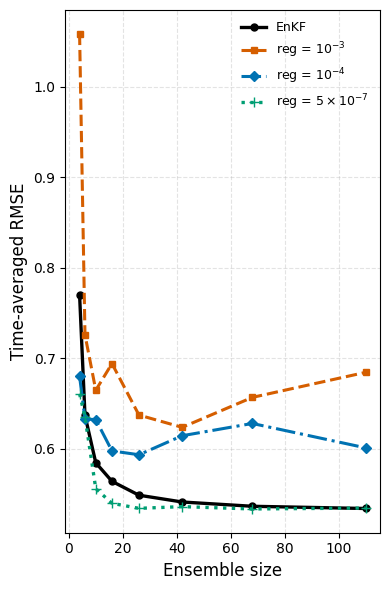

In [18]:
fig, ax = plot_kmed_rmse(
    N,
    e_mu_ek,
    e_mu_pk_lr,
    e_mu_pk_mr,
    e_mu_pk_sr,
    r"reg = $10^{-3}$",
    r"reg = $10^{-4}$",
    r"reg = $5\times 10^{-7}$",
    save_path="Plots/lorenz/old_le_pk.png"
)

In [17]:
def plot_kmed_rmse(
    N,
    e_mu_ek,
    e_mu_pk_lr,
    e_mu_pk_mr,
    e_mu_pk_sr,
    reg_lr,
    reg_mr,
    reg_sr,
    e_mu_mpf=None,                 # NEW
    title=None,
    save_path=None,
    mpf_inset=True,                # NEW
    inset_loc="center right",       # NEW
    inset_size="30%"               # NEW
):
    """
    Plot time-averaged RMSE vs ensemble size in a publication-ready style.
    Optionally include MPF (often off-scale at small N) via an inset.
    """

    fig, ax = plt.subplots(figsize=(4, 6))

    # --- EnKF (baseline) ---
    ax.plot(
        N, e_mu_ek,
        label="EnKF",
        color="black",
        linestyle="-",
        linewidth=2.4,
        marker="o",
        markersize=5
    )

    # --- KMED variants ---
    ax.plot(
        N, e_mu_pk_lr,
        label=reg_lr,
        color="#D55E00",
        linestyle="--",
        linewidth=2.2,
        marker="s",
        markersize=5
    )

    ax.plot(
        N, e_mu_pk_mr,
        label=reg_mr,
        color="#0072B2",
        linestyle="-.",
        linewidth=2.2,
        marker="D",
        markersize=5
    )

    ax.plot(
        N, e_mu_pk_sr,
        label=reg_sr,
        color="#009E73",
        linestyle=":",
        linewidth=2.4,
        marker="+",
        markersize=7
    )

    # ------------------------------------------------------------
    # MPF handling
    # ------------------------------------------------------------
    if e_mu_mpf is not None:
        mpf_color = "#CC79A7"  # consistent palette (purple-pink)

        if mpf_inset:
            # Proxy artist so MPF appears in the main legend (but not on main axis)
            ax.plot([], [], color=mpf_color, marker="*", linewidth=2.2,
                    linestyle="--", label="MPF")

            # Inset axis for MPF (to avoid flattening the main curves)
            ax_ins = inset_axes(ax, width=inset_size, height=inset_size,
                                loc=inset_loc, borderpad=1.0)

            ax_ins.plot(
                N, e_mu_mpf,
                color=mpf_color,
                linestyle="--",
                linewidth=2.0,
                marker="*",
                markersize=4
            )

            ax_ins.plot(
                N, e_mu_ek,
                color="black",
                linestyle="--",
                linewidth=2.0,
                marker="o",
                markersize=4
            )

            # ax_ins.set_title("MPF (different scale)", fontsize=8)
            ax_ins.grid(True, linestyle="--", alpha=0.30)
            ax_ins.tick_params(labelsize=8)

            # Optional: focus inset on the problematic small-N region
            # (comment out if you want full range)
            k = min(8, len(N) - 1)
            ax_ins.set_xlim(N[0], N[k])

        else:
            # Plot MPF directly on main axis (only do this if scales are comparable)
            ax.plot(
                N, e_mu_mpf,
                label="MPF",
                color=mpf_color,
                linestyle="--",
                linewidth=2.2,
                marker="o",
                markersize=5
            )

    # --- Axes, grid, legend ---
    ax.set_xlabel("Ensemble size", fontsize=12)
    ax.set_ylabel("Time-averaged RMSE", fontsize=12)
    if title is not None:
        ax.set_title(title, fontsize=13)

    ax.grid(True, linestyle="--", alpha=0.35)
    ax.tick_params(labelsize=10)

    ax.legend(frameon=False, fontsize=9, handlelength=2)

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    return fig, ax

C:\Users\linfe\AppData\Local\Temp\ipykernel_15692\1242750206.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


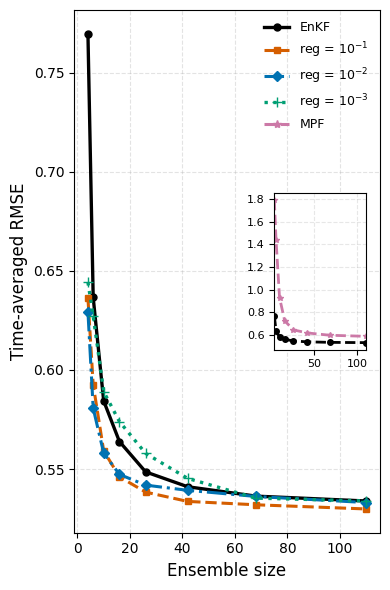

In [19]:
fig, ax = plot_kmed_rmse(
    N,
    e_mu_ek,
    e_mu_ka_lr,
    e_mu_ka_mr,
    e_mu_ka_sr,
    r"reg = $10^{-1}$",
    r"reg = $10^{-2}$",
    r"reg = $10^{-3}$",
    
    e_mu_mpf= e_mu_mpf,
    save_path="Plots/lorenz/old_le_ka.png"
)